In [1]:
# import modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.stats import zscore

# inline plots
%matplotlib inline

In [2]:
# read the data
dat_all = pd.read_excel('ADNI_ICM_random200.xlsx')
dat_all = dat_all.replace({'\'':''}, regex=True) # remove ' ' from data
dat_all = dat_all.rename(columns=lambda x:x.strip('\'')) # remove ' ' from column names
dat_all.index += 1 # change index to start at 1
#dat_all

In [3]:
# select only the columns of interest
rois = ['IFG_opercularis_L','IFG_orbitalis_L','IFG_triangularis_L','LFOG_L','MFG_L','MFOG_L','PrCG_L','SFG_L',
       'IFG_opercularis_R','IFG_orbitalis_R','IFG_triangularis_R','LFOG_R','MFG_R','MFOG_R','PrCG_R','SFG_R']
info = ['Subject_ID', 'Gender', 'Age', 'Diagnosis']
columns = np.concatenate((info, rois), axis=0)
dat = dat_all[columns]
#dat

In [4]:
# split into Alzheimer's group and control group
ad = dat[dat.Diagnosis == 'AD/MCI']
control = dat[dat.Diagnosis == 'NORMAL']

In [5]:
#ad

In [6]:
#control

In [7]:
# split patient info and volume data
ad_info = ad[info]
ad_volume = ad[rois]
control_info = control[info]
control_volume = control[rois]

In [8]:
#ad_volume

In [9]:
#control_volume

In [10]:
# create new df with mean and standard deviation for both groups
mean_std = pd.DataFrame({'ad_mean':ad_volume.mean(), 'ad_std':ad_volume.std(), 
                         'control_mean':control_volume.mean(), 'control_std':control_volume.std()})
#mean_std

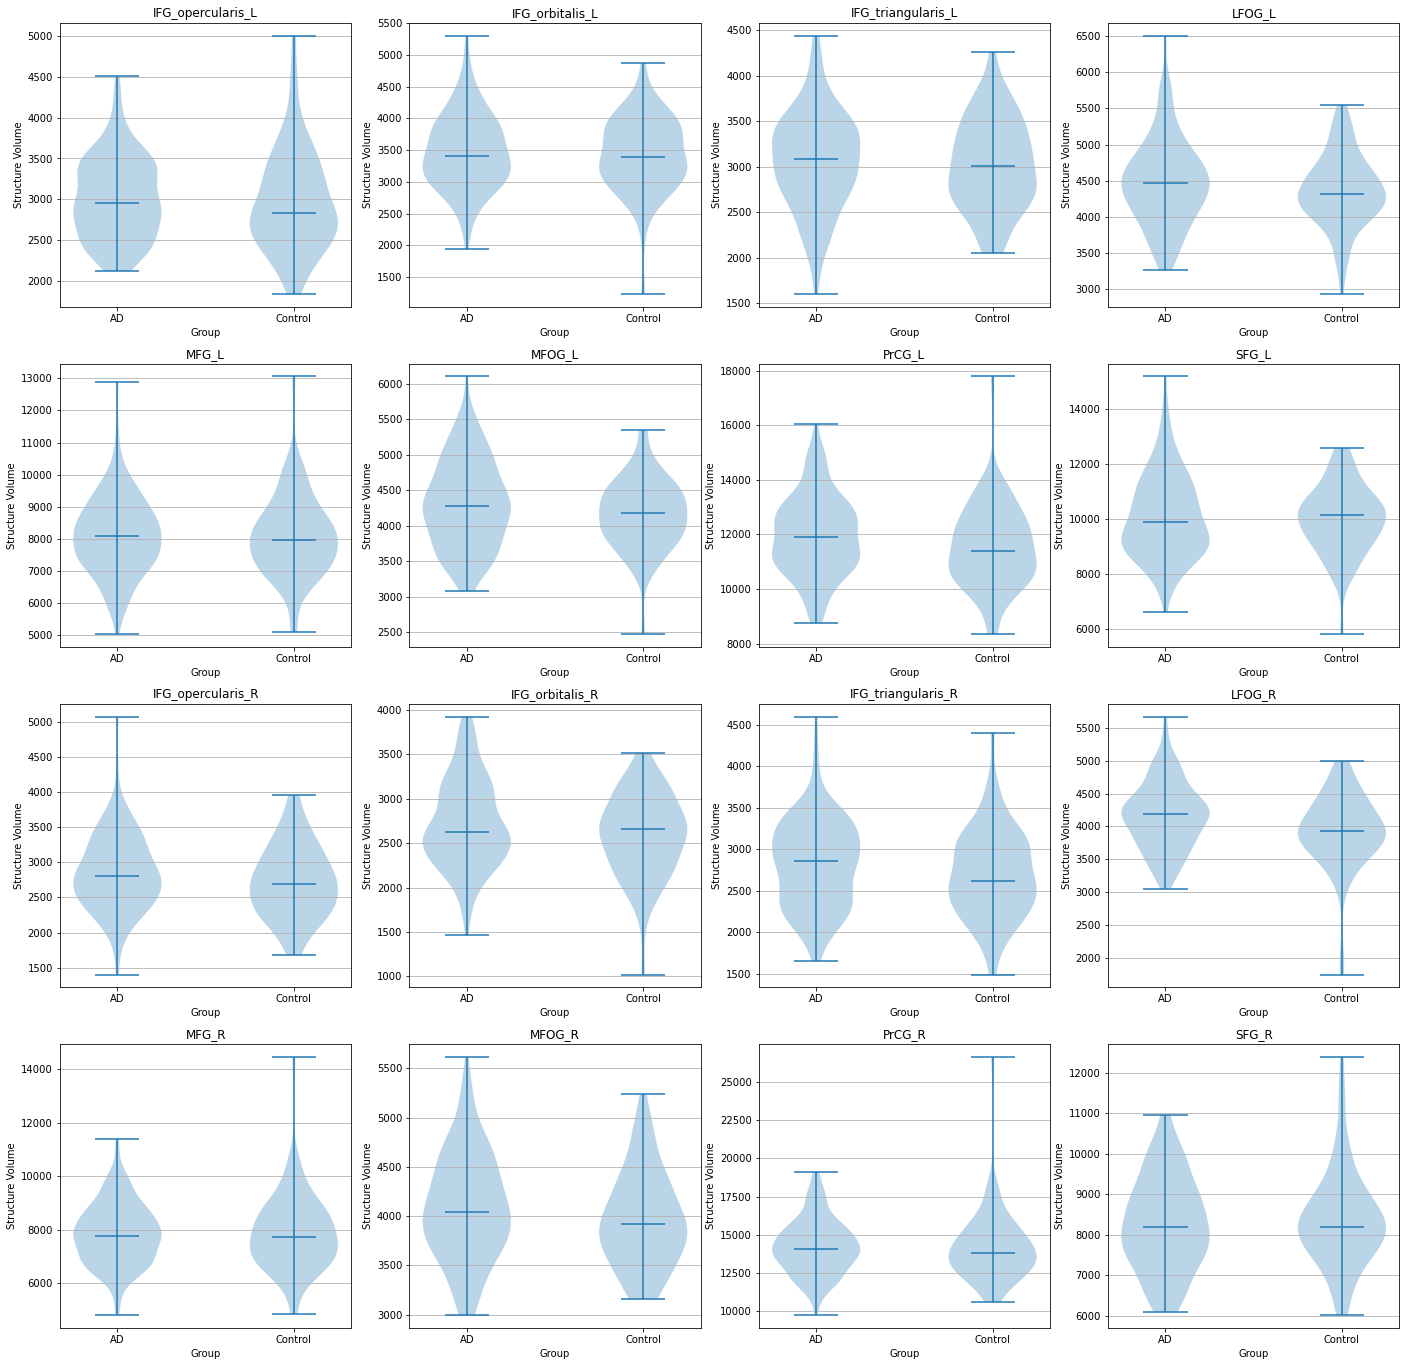

In [11]:
#violin plot to show the differences in structure volumes between AD and control group
#contact Chenyu Gao if you find anything wrong in this block

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 24))

# plot violin plot
for i in range(0,16):
    compare = [ad_volume.iloc[:,i],control_volume.iloc[:,i]] #collect data from AD and control group
    axes[i//4,i%4].violinplot(compare,
                   showmeans=False,
                   showmedians=True) #loop and plot
    axes[i//4,i%4].set_title(control_volume.columns[i])
    axes[i//4,i%4].set_xlabel('Group')
    axes[i//4,i%4].set_ylabel('Structure Volume')
    axes[i//4,i%4].yaxis.grid(True) #add horizontal grid line

# add x-tick labels
plt.setp(axes, xticks=[1,2],
         xticklabels=['AD', 'Control'])

plt.show()

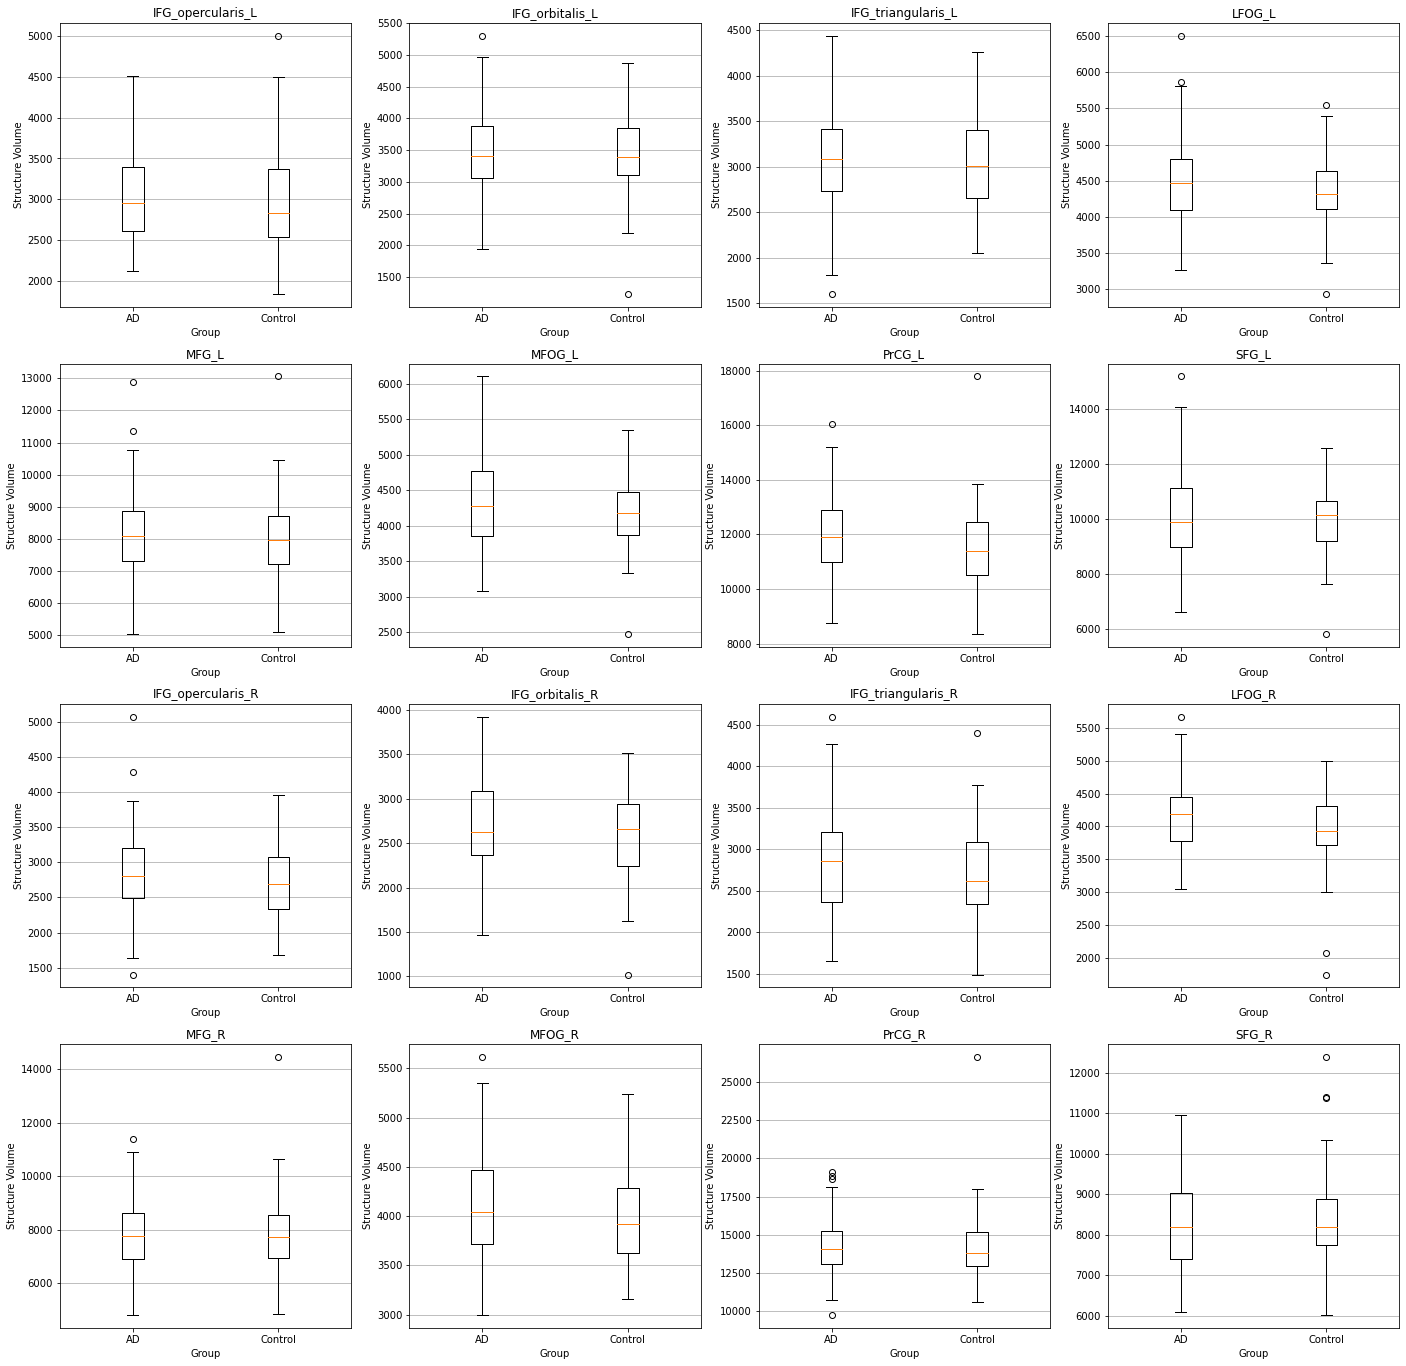

In [12]:
# box plot may look more scientific but contain less information I think
#contact Chenyu Gao if you find anything wrong in this block

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 24))

#plot box plot
for i in range(0,16):
    compare = [ad_volume.iloc[:,i],control_volume.iloc[:,i]] #collect data from AD and control group
    axes[i//4,i%4].boxplot(compare)#loop and plot
    axes[i//4,i%4].set_title(control_volume.columns[i])
    axes[i//4,i%4].set_xlabel('Group')
    axes[i//4,i%4].set_ylabel('Structure Volume')
    axes[i//4,i%4].yaxis.grid(True) #add horizontal grid line

# add x-tick labels
plt.setp(axes, xticks=[1,2],
         xticklabels=['AD', 'Control'])

plt.show()


In [13]:
# calculate z-scores for each patient
ad_zscore = ad_volume.apply(zscore)
control_zscore = control_volume.apply(zscore)

In [14]:
#ad_zscore

In [15]:
#control_zscore

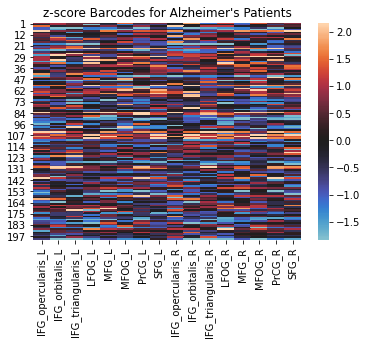

In [16]:
# heat map for all Alzheimer's patients
ax1 = sns.heatmap(ad_zscore, robust=True, center=0)
ax1.set(title = "z-score Barcodes for Alzheimer's Patients");

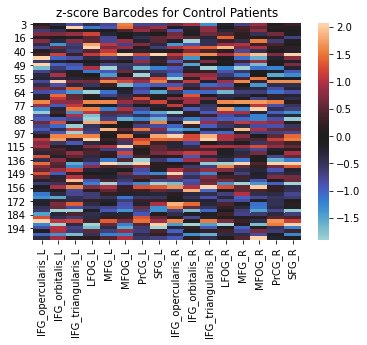

In [17]:
# heat map for all control patients
ax2 = sns.heatmap(control_zscore, robust=True, center=0)
ax2.set(title = "z-score Barcodes for Control Patients");

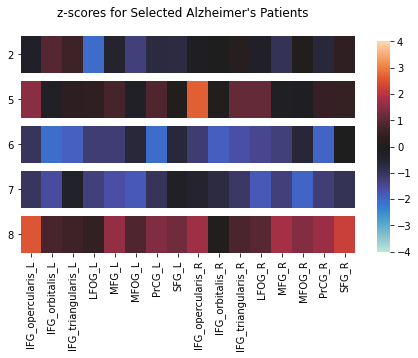

In [18]:
# selected heat maps
fig, axn = plt.subplots(5,1)
cbar_ax = fig.add_axes([0.95, 0.13, 0.03, .73])

plt.subplot(5,1,1)
sns.heatmap(ad_zscore.iloc[1:2], xticklabels= False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(5,1,2)
sns.heatmap(ad_zscore.iloc[2:3], xticklabels= False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(5,1,3)
sns.heatmap(ad_zscore.iloc[3:4], xticklabels= False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(5,1,4)
sns.heatmap(ad_zscore.iloc[4:5], xticklabels= False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(5,1,5)
sns.heatmap(ad_zscore.iloc[5:6], vmin=-4, vmax=4, center=0, cbar_ax=cbar_ax)
plt.yticks(rotation=0) 

fig.suptitle('z-scores for Selected Alzheimer\'s Patients');